In [1]:
import numpy as np
import pandas as pd

import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
pd.options.mode.chained_assignment = None

# Домашнее задание по курсу анализа данных
Версия от 12.10.2021

Всего 50 баллов = 40 основных + 10 дополнительных

Оценка  = Количество баллов за работу*2/10

Автор: Миленькин Александр

Автор готового ДЗ: Ерёменко Дмитрий Олегович

In [2]:
df = pd.read_csv('/home/lada/Загрузки/people_data_clustering.csv' , index_col=0)
print('Размеры',df.shape)
df.head()

Размеры (6000, 9)


,id,was_married,childrens,salary,sex,age,profession,home_cost,drive_info
0,0,1,4.0,45032.40,1,82.0,Engineer,1.003674e+07,NaN
1,1,1,2.0,202004.64,1,32.0,Doctor,1.014051e+07,0.0
2,2,1,6.0,213158.75,1,14.0,Entertainment,1.043318e+07,NaN
3,3,0,1.0,185692.78,0,10.0,Lawyer,1.004299e+07,NaN
4,4,1,9.0,132067.32,1,99.0,Artist,1.021908e+07,NaN


<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой информацию по жителям некоторого города.

* `was_married` - Был ли когда-либо женат/замужем
* `childrens` - Количество детей
* `salary` - Уровень зарплаты
* `sex` - Пол
* `age` - Возраст
* `home_cost` - Стоимость жилья
* `Professon` - Профессия
* `drive_info` - Есть ли водительские права
    
</div>

<div class="alert alert-info">
<b>Задание</b>

Изучить датасет и, используя класстерный анализ, разбить пользователей на сегменты. Сделать выводы о причинах такой кластеризации.

# Изучение датасета (5 баллов)
* 1. Какие признаки численные?
* 2. Какие признаки категориальные?
* 3. Какие признаки бинарные?
* 4. Какие признаки имеют нормальное распределение?
* 5. Какие признаки бессмысленные?

Ответы приведены в конце. 

__Определение типов  признаков.__

In [3]:
df.dtypes

id               int64
was_married      int64
childrens      float64
salary         float64
sex              int64
age            float64
profession      object
home_cost      float64
drive_info     float64
dtype: object

__1. 2. Автоматизированная выборка численных и категориальных признаков:__

In [4]:
print('Численные признаки:',df.select_dtypes(include=['int64', 'float64']).columns.tolist())
print('Категориальные признаки:',df.select_dtypes(include=['object']).columns.tolist())

Численные признаки: ['id', 'was_married', 'childrens', 'salary', 'sex', 'age', 'home_cost', 'drive_info']
Категориальные признаки: ['profession']


__3. К бинарным относятся данные типа boolean, принимающие True или False.Однако в датасете таких нет, но есть признаки принимающие значения 0 и 1, на основе этого можем условно отнести их к бинарным. 
Такими признаки являются: 
['was_married', 'sex', 'drive_info]__ 

__4. Проведем анализ графиков и выберем признаки с нормальным распределением:__

<AxesSubplot:title={'center':'drive_info'}, ylabel='Density'>

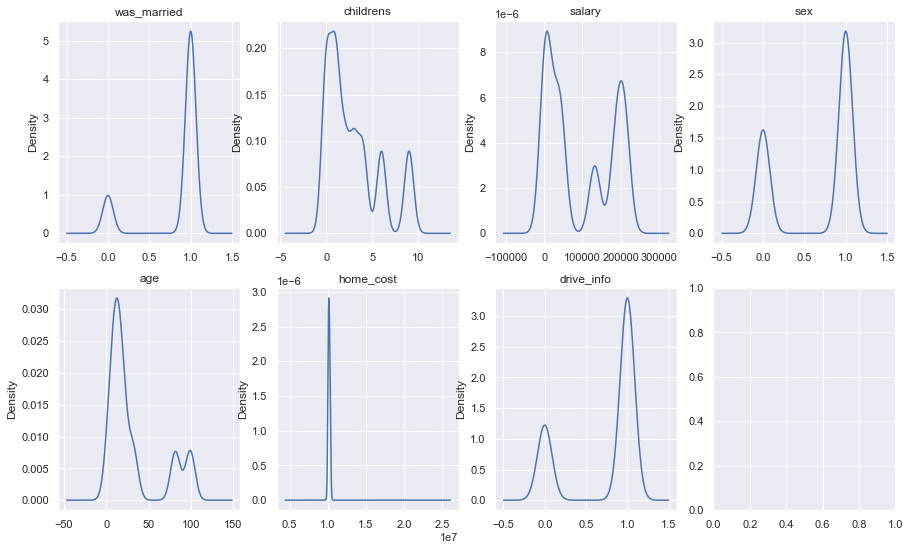

In [5]:
# Создадим "сетку" для отрисовки графиков распределения
fig, axs = plt.subplots(2, 4)

#В каждой ячейке отрисуем график распределения для каждого признака, дадим название графику
#     (признак ['profession'] не учитываем, т.к. тип object)
df['was_married'].plot(kind='density', ax = axs[0, 0], title = 'was_married', figsize = (15,9))
df['childrens'].plot(kind='density', ax = axs[0, 1], title = 'childrens')
df['salary'].plot(kind='density', ax = axs[0, 2], title = 'salary')
df['sex'].plot(kind='density', ax = axs[0, 3], title = 'sex')
df['age'].plot(kind='density', ax = axs[1, 0], title = 'age')
df['home_cost'].plot(kind='density', ax = axs[1, 1], title = 'home_cost')
df['drive_info'].plot(kind='density', ax = axs[1, 2], title = 'drive_info')

__Исходя из графиков наблюдаем, что нормальное распределение имеет только признак ['home_cost']__

__Бессмысленными признаками считаем ['id'] (тк это идентификатор строк) и ['drive_info'] (т.к. исходя из дальнейших выводов будет видно, что признак содержит 46% пропущенных данных и его можно смело удалить.__

#  <span style='color:green'>Ответы по датасету: </span>
Численные признаки: ['id', 'was_married', 'childrens', 'salary', 'sex', 'age', 'home_cost', 'drive_info']

Категориальные признаки:['profession']

Бинарные признаки:['was_married', 'sex', 'drive_info']

Признак с нормальным рапределением:['home_cost]

Бессмысленные признаки: ['id', 'drive_info']

# Чистка датасета (5 баллов)
* 1. Есть ли дубли в данных? 
* 2. Есть ли пропуски в данных? 
* 3. Как стоит поступить с выбросами? (удалить или заменить \ `dropna()` или `fillna()` )
* 4. Удалить бесмысленные признаки (`drop()`)
* 5. Найти и удалить выбросы по признаку `home_cost`. Сколько их?

__1. Определим количество дублированных строк в датафрейме с подсчетом таких дублей для каждой повторяемой строки (столбец ['size']):__

In [6]:
df_group = df.groupby(df.columns.tolist(),as_index=False).size()
df_group

,id,was_married,childrens,salary,sex,age,profession,home_cost,drive_info,size
0,1,1,2.0,202004.64,1,32.0,Doctor,1.014051e+07,0.0,2
1,5,1,3.0,999.61,0,21.0,Homemaker,1.001654e+07,1.0,2
2,7,1,2.0,201589.78,1,32.0,Doctor,1.022668e+07,1.0,2
3,8,1,1.0,12912.69,1,9.0,Marketing,1.017361e+07,1.0,2
4,10,1,9.0,131822.41,1,100.0,Artist,1.037684e+07,1.0,2
...,...,...,...,...,...,...,...,...,...,...
2971,5493,1,6.0,215188.93,1,13.0,Entertainment,1.031287e+07,1.0,1
2972,5494,1,3.0,999.12,0,21.0,Homemaker,9.995216e+06,0.0,1
2973,5495,1,1.0,12676.77,1,9.0,Marketing,1.027045e+07,0.0,1
2974,5496,1,6.0,215570.69,1,13.0,Entertainment,1.032767e+07,1.0,1


Если в столбце ['size'] содержится уникальная строка -> значение = 1. Если же строка имеет дубликаты, то в столбце будет записано количество дубликатов. Сделаем выборку для определения количества дубликатов (запрос к датафрейму, если 'size' > 1

In [7]:
df_group.query('size > 1').count()

id             254
was_married    254
childrens      254
salary         254
sex            254
age            254
profession     254
home_cost      254
drive_info     254
size           254
dtype: int64

__Всего 254 неуникальных записей (строк) - дубликатов__

__2. Проверка наличия пропусков данных:__

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           6000 non-null   int64  
 1   was_married  6000 non-null   int64  
 2   childrens    6000 non-null   float64
 3   salary       6000 non-null   float64
 4   sex          6000 non-null   int64  
 5   age          6000 non-null   float64
 6   profession   6000 non-null   object 
 7   home_cost    6000 non-null   float64
 8   drive_info   3230 non-null   float64
dtypes: float64(5), int64(3), object(1)
memory usage: 468.8+ KB


__Признак 'drive_info' имеет пропуски (а именно: 6000 - 3230 = <span style='color:red'>2770 пропусков (~46%)</span>)__

__3. Выбросы лучше заменить на медианные значения (использовать метод fillna):__

__4. Применим метод drop  для бессмысленных признаков: ['id], ['drive_info']. Новый dataframe drop_df будет содержать оставшиеся признаки.__

In [9]:
drop_df = df.drop(columns=['id', 'drive_info'])
drop_df

,was_married,childrens,salary,sex,age,profession,home_cost
0,1,4.0,45032.40,1,82.0,Engineer,1.003674e+07
1,1,2.0,202004.64,1,32.0,Doctor,1.014051e+07
2,1,6.0,213158.75,1,14.0,Entertainment,1.043318e+07
3,0,1.0,185692.78,0,10.0,Lawyer,1.004299e+07
4,1,9.0,132067.32,1,99.0,Artist,1.021908e+07
...,...,...,...,...,...,...,...
5995,1,0.0,37023.38,1,3.0,Executive,1.007038e+07
5996,1,3.0,999.66,0,20.0,Homemaker,1.009348e+07
5997,1,0.0,2042.76,0,17.0,Healthcare,1.016696e+07
5998,0,1.0,186560.45,0,10.0,Lawyer,1.025544e+07


__5. Определим выбросы признака ['home_cost'] и их количество с помощью построения boxplot:__

<AxesSubplot:>

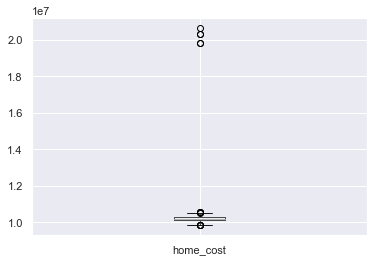

In [10]:
drop_df.boxplot(column= ['home_cost'])

Определить точное количество с помощью boxplot не получится, поэтому создадим колонку Outlier, корая принимает значения true (если значение признака не выходит за нижнюю и верхнюю границу) и false (если значение признака считается выбросом)

In [11]:
q1 = drop_df['home_cost'].quantile(0.001)
q3 = drop_df['home_cost'].quantile(0.999)

drop_df['Outlier'] = drop_df['home_cost'].between(q1, q3)
drop_df.query('Outlier == False').count()

was_married    12
childrens      12
salary         12
sex            12
age            12
profession     12
home_cost      12
Outlier        12
dtype: int64

Пока получаем 12 выбросов

Создадим функцию, высчитывающую размах, который могут иметь значения признака. Значение, не входящие в этот размах, будет отбрасываться

In [12]:
def remove_outlier(df, col_names):
    q1 = df[col_names].quantile(0.25)
    q3 = df[col_names].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df = df.loc[(df[col_names] > fence_low) & (df[col_names] < fence_high)]
    return df

Применим функцию к нашему новому датафрейму (созданному ранее) и отрисуем для признака ['home_cost'] boxplot

<AxesSubplot:>

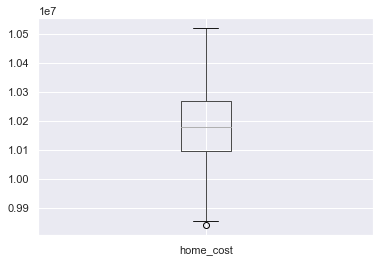

In [13]:
drop_df = remove_outlier(drop_df, 'home_cost')
drop_df.boxplot(column= ['home_cost'])

Уже лучше, но выбосы все еще есть, повтрим процедуру

<AxesSubplot:>

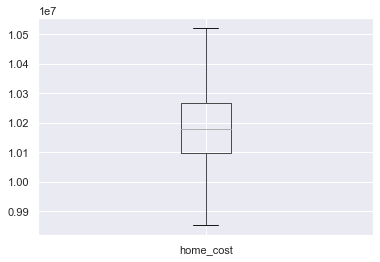

In [14]:
drop_df = remove_outlier(drop_df, 'home_cost')
drop_df.boxplot(column= ['home_cost'])

Опять посчитаем количество выбросов:

In [15]:
drop_df.query('Outlier == False').count()

was_married    1
childrens      1
salary         1
sex            1
age            1
profession     1
home_cost      1
Outlier        1
dtype: int64

__Выбросов больше нет__

__Итого количество выбросов: 12 + 1 = 13__

# Изучение зависимых признаков (5 балла). 
* 1. Построить матрицу корреляций
* 2. Визуализировать матрицу корреляции с помощью heatmap
* 3. Сделать выводы по самым скоррелированные признакам
* 4. Построить график зависимости между двумя самыми зависимыми признками



__1. Построение матрицы корреляции:__

,id,was_married,childrens,salary,sex,age,home_cost,drive_info
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6.000000e+03,3230.000000
mean,2541.166667,0.842000,2.887167,92110.049587,0.661833,31.776667,1.018381e+07,0.729102
std,1670.447706,0.364771,2.850285,85255.778747,0.473125,32.546372,1.191820e+05,0.444492
min,0.000000,0.000000,0.000000,997.140000,0.000000,2.000000,9.824378e+06,0.000000
25%,999.750000,1.000000,1.000000,12521.570000,0.000000,10.000000,1.009639e+07,0.000000
50%,2499.500000,1.000000,2.000000,45221.445000,1.000000,17.000000,1.017716e+07,1.000000
75%,3999.250000,1.000000,4.000000,186389.350000,1.000000,32.000000,1.026920e+07,1.000000
max,5499.000000,1.000000,9.000000,217776.450000,1.000000,100.000000,1.054312e+07,1.000000


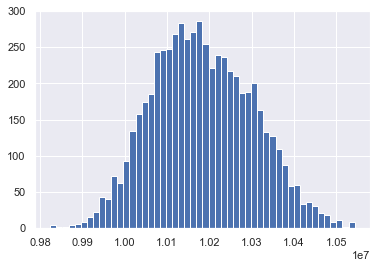

In [16]:
new_df = df
q = np.quantile(new_df['home_cost'], 0.999) 
new_df['home_cost'] = np.clip(new_df['home_cost'], None, q)
new_df['home_cost'].hist(bins=50)
#new_df = new_df.drop(columns=['clip_home_cost'])
new_df.describe()

In [17]:
corr_matrix = new_df.corr(method='pearson')
corr_matrix

,id,was_married,childrens,salary,sex,age,home_cost,drive_info
id,1.000000,-0.011870,-0.008735,0.003222,0.026312,0.008840,0.005169,0.003456
was_married,-0.011870,1.000000,0.242263,-0.499884,0.337497,0.200650,-0.338854,0.009968
childrens,-0.008735,0.242263,1.000000,0.395872,0.388888,0.743052,0.283896,0.012938
salary,0.003222,-0.499884,0.395872,1.000000,0.248348,0.078350,0.706481,-0.003884
sex,0.026312,0.337497,0.388888,0.248348,1.000000,0.341431,0.183984,0.003568
age,0.008840,0.200650,0.743052,0.078350,0.341431,1.000000,0.052225,0.009518
home_cost,0.005169,-0.338854,0.283896,0.706481,0.183984,0.052225,1.000000,0.000408
drive_info,0.003456,0.009968,0.012938,-0.003884,0.003568,0.009518,0.000408,1.000000


__2. Визуализируем матрицу корреляции с помощью heatmap__

Для анализа добавим данные о профессии и построим матрицу корреляции:

In [18]:
kach_prizn = pd.get_dummies(new_df['profession'])
df_for_corr = new_df.drop(['profession'], axis = 1)
df_for_corr = new_df.join(kach_prizn)
corr = df_for_corr.corr()
corr

,id,was_married,childrens,salary,sex,age,home_cost,drive_info,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing
id,1.000000,-0.011870,-0.008735,0.003222,0.026312,0.008840,0.005169,0.003456,-0.003773,0.020385,0.018959,-0.017401,0.022230,-0.019447,-0.017959,-0.002889,0.000538
was_married,-0.011870,1.000000,0.242263,-0.499884,0.337497,0.200650,-0.338854,0.009968,0.153455,-0.254501,0.151642,0.153326,0.152291,0.154871,0.154100,-0.818467,0.153068
childrens,-0.008735,0.242263,1.000000,0.395872,0.388888,0.743052,0.283896,0.012938,0.759800,-0.109248,0.136686,0.386587,-0.356140,-0.362175,0.014084,-0.234764,-0.233975
salary,0.003222,-0.499884,0.395872,1.000000,0.248348,0.078350,0.706481,-0.003884,0.166617,0.451150,-0.192324,0.506055,-0.230581,-0.377761,-0.380197,0.389807,-0.329271
sex,0.026312,0.337497,0.388888,0.248348,1.000000,0.341431,0.183984,0.003568,0.253221,0.250872,0.244581,0.253008,0.251300,-0.500158,-0.497666,-0.496001,0.252582
age,0.008840,0.200650,0.743052,0.078350,0.341431,1.000000,0.052225,0.009518,0.736240,0.002736,0.538252,-0.199253,-0.310884,-0.161994,-0.120006,-0.233555,-0.247306
home_cost,0.005169,-0.338854,0.283896,0.706481,0.183984,0.052225,1.000000,0.000408,0.119034,0.319052,-0.141415,0.365767,-0.152741,-0.272416,-0.265063,0.263913,-0.233611
drive_info,0.003456,0.009968,0.012938,-0.003884,0.003568,0.009518,0.000408,1.000000,-0.000643,-0.002666,0.015492,0.001533,0.022938,-0.027939,0.031205,-0.009910,-0.029242
Artist,-0.003773,0.153455,0.759800,0.166617,0.253221,0.736240,0.119034,-0.000643,1.000000,-0.124328,-0.124010,-0.125387,-0.124540,-0.126651,-0.126020,-0.125598,-0.125175
Doctor,0.020385,-0.254501,-0.109248,0.451150,0.250872,0.002736,0.319052,-0.002666,-0.124328,1.000000,-0.122859,-0.124224,-0.123385,-0.125476,-0.124851,-0.124433,-0.124014


Отрисуем матрицу корреляции на тепловой карте

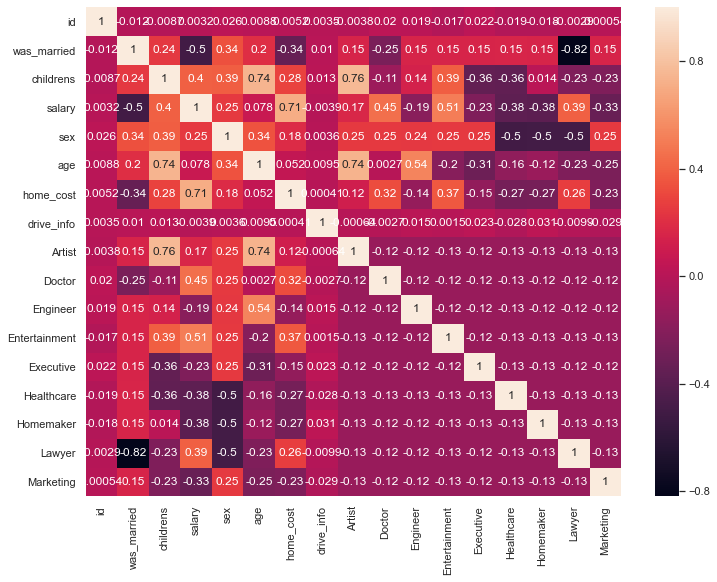

In [19]:
plt.figure(figsize=(12, 9))
matr_corr = sns.heatmap(corr, annot = True)

__3. Выводы по самым скоррелированным признакам:__

Наибольшее значение корреляции имеет пара признаков <span style='color:red'>['__Artist__']</span> -- <span style='color:red'>['__childrens__']</span> , <span style='color:red'>['__age__']</span> -- <span style='color:red'>['__childrens__']</span>  и <span style='color:red'>['__salary__']</span> -- <span style='color:red'>['__home_cost'__]</span> со значениями корреляции 0.76, 0.74 и 0.71 соответственно. Данное значение корреляции находится между определением строгой прямой (значение корреляции = 1) и слабой прямой (зачения корреляции около 0,5) связью. 

Также стоит отметить еще несколько пар признаков со слабой прямой зависимостью: ['__sex__'] -- ['__childrens__'] и ['__salary__'] -- ['__childrens__'], значения корреляции у которых прнимают значения 0,39 и 0,4 соответственно.

__4. График зависимости между двумя самыми зависимыми признаками:__

а) меду признаками ['salary'] -- ['home_cost'] :

<Figure size 936x1296 with 0 Axes>

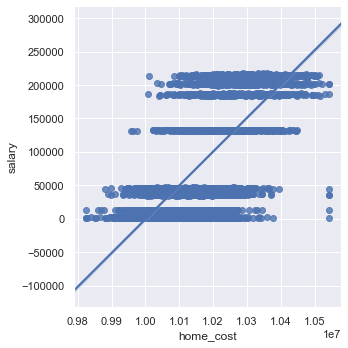

In [20]:
plt.figure(figsize=(13,18));
sns.lmplot(data=df_for_corr, x='home_cost', y = 'salary');

б) между признаками ['age'] -- ['childrens'] 

<Figure size 936x1296 with 0 Axes>

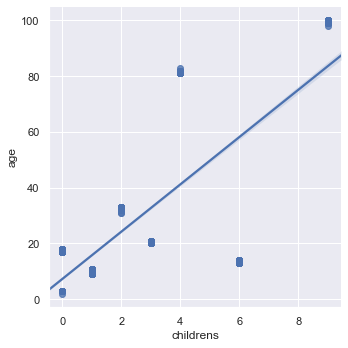

In [21]:
plt.figure(figsize=(13,18));
sns.lmplot(data=df_for_corr, x='childrens', y = 'age');

в) между признаками ['Artist'] -- ['childrens']

<Figure size 936x1296 with 0 Axes>

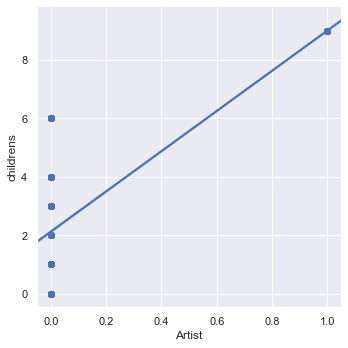

In [22]:
plt.figure(figsize=(13,18));
sns.lmplot(data=df_for_corr, x='Artist', y = 'childrens');

# Нормировка признаков (3 балла)
* Отнормировать данные
* Обосновать выбор нормировки

In [23]:
df_for_normal = df
df_for_normal = df_for_normal.drop(columns=['id', 'was_married', 'sex', 'profession', 'drive_info'])
df_for_normal

,childrens,salary,age,home_cost
0,4.0,45032.40,82.0,1.003674e+07
1,2.0,202004.64,32.0,1.014051e+07
2,6.0,213158.75,14.0,1.043318e+07
3,1.0,185692.78,10.0,1.004299e+07
4,9.0,132067.32,99.0,1.021908e+07
...,...,...,...,...
5995,0.0,37023.38,3.0,1.007038e+07
5996,3.0,999.66,20.0,1.009348e+07
5997,0.0,2042.76,17.0,1.016696e+07
5998,1.0,186560.45,10.0,1.025544e+07


In [24]:
scaler = RobustScaler()
arr_scaled = scaler.fit_transform(df_for_normal)
df_scaler = pd.DataFrame(arr_scaled, columns=df_for_normal.columns, index=df_for_normal.index)
print(df_scaler)

      childrens    salary       age  home_cost
0      0.666667 -0.001087  2.954545  -0.812596
1      0.000000  0.901738  0.681818  -0.212089
2      1.333333  0.965891 -0.136364   1.481554
3     -0.333333  0.807920 -0.318182  -0.776479
4      2.333333  0.499494  3.727273   0.242577
...         ...       ...       ...        ...
5995  -0.666667 -0.047151 -0.636364  -0.617941
5996   0.333333 -0.254341  0.136364  -0.484248
5997  -0.666667 -0.248342  0.000000  -0.059054
5998  -0.333333  0.812911 -0.318182   0.452993
5999   0.333333 -0.254335  0.181818   0.564757

[6000 rows x 4 columns]


__Обоснование выбора нормирования:__

Выбранные метод нормирования - RobustScaler, потому как наш датафрейм содержит выбросы по признакам ['childrens', 'salary', 'age' 'home_cost']. Рассмотренный нами  метод  используют как раз  для масштабирования данных с выбросами. Среднее и стандартное отклонение не устойчивы к выбросам, поэтому этот скалер использует медиану и масштабирует данные до квантильных диапазонов.


In [25]:
df_scaler

,childrens,salary,age,home_cost
0,0.666667,-0.001087,2.954545,-0.812596
1,0.000000,0.901738,0.681818,-0.212089
2,1.333333,0.965891,-0.136364,1.481554
3,-0.333333,0.807920,-0.318182,-0.776479
4,2.333333,0.499494,3.727273,0.242577
...,...,...,...,...
5995,-0.666667,-0.047151,-0.636364,-0.617941
5996,0.333333,-0.254341,0.136364,-0.484248
5997,-0.666667,-0.248342,0.000000,-0.059054
5998,-0.333333,0.812911,-0.318182,0.452993


In [27]:
df_scaler = df_scaler.join(df[['sex', 'was_married']])
df_scaler

,childrens,salary,age,home_cost,sex,was_married
0,0.666667,-0.001087,2.954545,-0.812596,1,1
1,0.000000,0.901738,0.681818,-0.212089,1,1
2,1.333333,0.965891,-0.136364,1.481554,1,1
3,-0.333333,0.807920,-0.318182,-0.776479,0,0
4,2.333333,0.499494,3.727273,0.242577,1,1
...,...,...,...,...,...,...
5995,-0.666667,-0.047151,-0.636364,-0.617941,1,1
5996,0.333333,-0.254341,0.136364,-0.484248,0,1
5997,-0.666667,-0.248342,0.000000,-0.059054,0,1
5998,-0.333333,0.812911,-0.318182,0.452993,0,0


# Выделить кластеры (6 баллов)
* Определить оптимальное количество кластеров с помощью правила локтя/осыпи
* Получить номера класстеров для каждого пользователя. 

__1. Определим оптимальное количество кластеров в помощью метода локтя :__

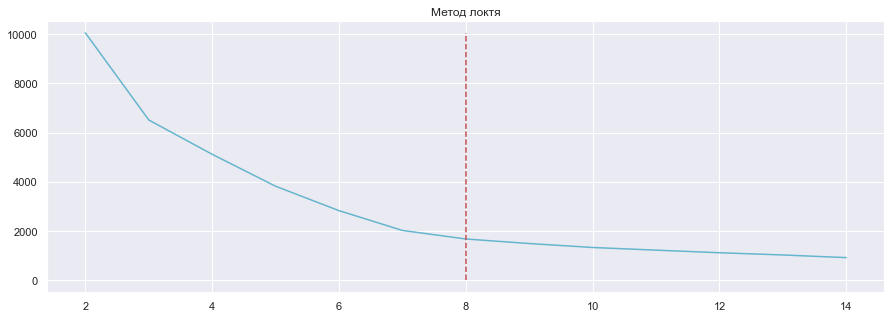

In [28]:
X = df_scaler
distorsions = []
min_range, max_range = 2, 15
for k in range(min_range, max_range):
    kmeans = KMeans(n_clusters=k, random_state=7)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

plt.figure(figsize=(15, 5))
plt.plot(range(min_range, max_range), distorsions, 'c')
plt.grid(True)
plt.title('Метод локтя');

y = [0, int(max(distorsions))]
x = [8, 8]
plt.plot(x, y, '--r');

Из графика видно, что можно попробовать взять количество кластеров, равное 9  и 10

__2.  Получим количество элементов для каждого из кластера:__

Для 8 кластеров:

In [29]:
n_clusters = [8, 9, 10]
clusterer_1 = KMeans(n_clusters=n_clusters[0], random_state=42, max_iter=500)
clusterer_labels_1 = clusterer_1.fit_predict(df_scaler)
print(np.unique(clusterer_labels_1, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([ 669,  662,  680,  655, 1323,  673,  668,  670]))


Для 9 кластеров:

In [30]:
n_clusters = [8, 9, 10]
clusterer_2 = KMeans(n_clusters=n_clusters[1], random_state=42, max_iter=500)
clusterer_labels_2 = clusterer_2.fit_predict(df_scaler)
print(np.unique(clusterer_labels_2, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32), array([668, 673, 669, 645, 659, 655, 670, 679, 682]))


Для 10 кластеров:

In [38]:
n_clusters = [8, 9, 10]
clusterer_3 = KMeans(n_clusters=n_clusters[2], random_state=42, max_iter=500)
clusterer_labels_3 = clusterer_3.fit_predict(df_scaler)
print(np.unique(clusterer_labels_3, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([669, 381, 666, 655, 661, 673, 668, 670, 278, 679]))


# Снизить разерность (6 баллов)

Воспользуйтесь методом t-SNE ()

ссылка на документацию:
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [32]:
df_scaler

,childrens,salary,age,home_cost,sex,was_married
0,0.666667,-0.001087,2.954545,-0.812596,1,1
1,0.000000,0.901738,0.681818,-0.212089,1,1
2,1.333333,0.965891,-0.136364,1.481554,1,1
3,-0.333333,0.807920,-0.318182,-0.776479,0,0
4,2.333333,0.499494,3.727273,0.242577,1,1
...,...,...,...,...,...,...
5995,-0.666667,-0.047151,-0.636364,-0.617941,1,1
5996,0.333333,-0.254341,0.136364,-0.484248,0,1
5997,-0.666667,-0.248342,0.000000,-0.059054,0,1
5998,-0.333333,0.812911,-0.318182,0.452993,0,0


In [33]:
from sklearn.decomposition import PCA
data_x_y = PCA(n_components=2, random_state=7).fit_transform(df_scaler)

# Нарисовать полученные кластеры (10 баллов)

Кластеризация при количестве кластеров = 8
Определение кластеров: [0 1 2 3 4 5 6 7],
Количество элементов в каждом из кластеров: [ 669  662  680  655 1323  673  668  670]


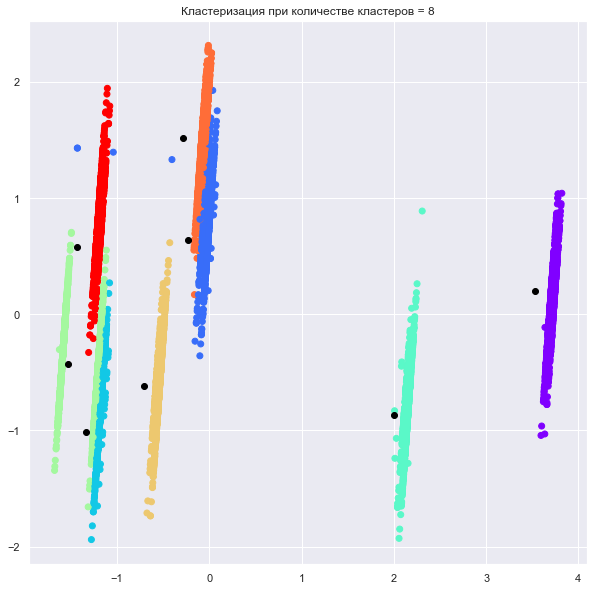

Кластеризация при количестве кластеров = 9
Определение кластеров: [0 1 2 3 4 5 6 7 8],
Количество элементов в каждом из кластеров: [668 673 669 645 659 655 670 679 682]


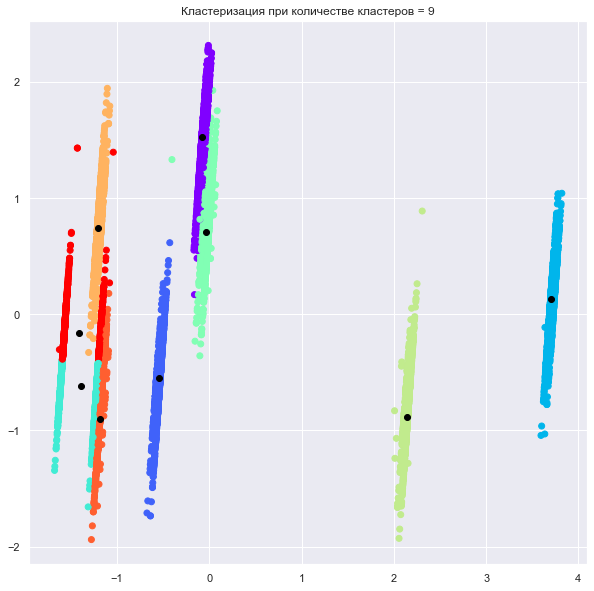

Кластеризация при количестве кластеров = 10
Определение кластеров: [0 1 2 3 4 5 6 7 8 9],
Количество элементов в каждом из кластеров: [669 381 666 655 661 673 668 670 278 679]


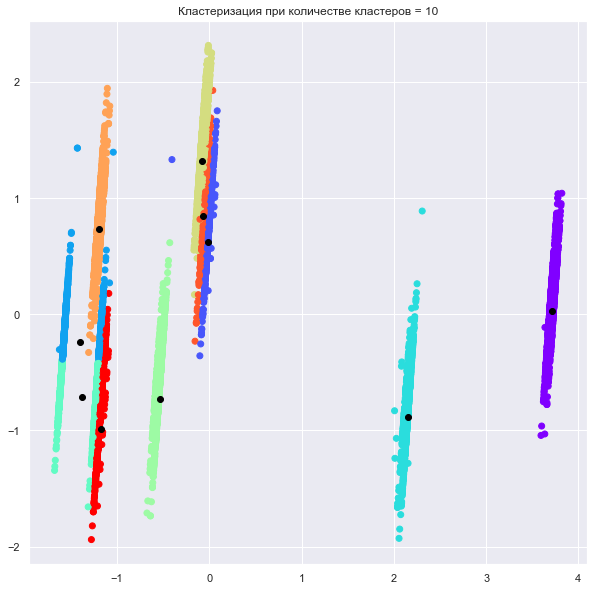

In [45]:
n_clusters = [8, 9, 10]

for i in range(0, len(n_clusters)):
    clusterer = KMeans(n_clusters=n_clusters[i], random_state=42, max_iter=500)
    cluster_labels = clusterer.fit_predict(df_scaler)
    print(f"Кластеризация при количестве кластеров = {n_clusters[i]}")

    print(f"Определение кластеров: {np.unique(cluster_labels, return_counts=True)[0]},\nКоличество элементов в каждом из кластеров: {np.unique(cluster_labels, return_counts=True)[1]}")

    data_x_y_cluster_centers = PCA(n_components=2, random_state=42).fit_transform(clusterer.cluster_centers_)

    plt.figure(figsize=(10,10))
    plt.scatter(data_x_y[:,0], data_x_y[:,1], c=cluster_labels, cmap ='rainbow')
    plt.scatter(data_x_y_cluster_centers[:,0], data_x_y_cluster_centers[:,1], color='black')
    plt.title(f"Кластеризация при количестве кластеров = {n_clusters[i]}")
    plt.show()

# Дополнительные баллы (+10 баллов)
* Аккуратный и понятный код **+5 баллов**
* Присутствуют лаконичные и понятные комментарии **+5 балов**